# RL and Advanced DL: Домашнее задание 2

Второе домашнее задание опять посвящено игре; его базовая часть, надеюсь, не слишком большая, но я добавил опциональную часть, которая, думаю, должна быть достаточно интересной для любого слушателя. Как обычно, в качестве решения ожидается ссылка на jupyter-ноутбук на вашем github (или публичный, или с доступом для snikolenko); ссылку обязательно нужно прислать в виде сданного домашнего задания на портале Академии. Любые комментарии, новые идеи и рассуждения на тему, как всегда, категорически приветствуются.  

<img src="tictactoe.png" width="600">
<!-- ![title](tictactoe.png) -->

In [1]:
import numpy as np
from tqdm import tqdm
from tictactoe_env import TicTacToe
from collections import defaultdict
import random
import matplotlib.pyplot as plt

## Часть первая: крестики-нолики при помощи Q-обучения
В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.
1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.
2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4 и/или 5х5.
**Disclaimer:** начиная с пункта 2, задания для досок размера больше 4х4 могут потребовать большого терпения или более сложных вычислительных реализаций (например, параллелизации). Не хочу в этом задании непременно требовать ни того ни другого, так что если не будет получаться доучить до победных стратегий, не страшно -- но покажите, что со временем что-то всё-таки улучшается.

In [2]:
def reflect_state(state: str):
    return state.replace('0', 't').replace('2', '0').replace('t', '2')
print(reflect_state('102021210'))

120201012


In [3]:
EMPTY_CODE, X_CODE, O_CODE = '102'
def get_free_spaces(state):
    return np.array([i for i, x in enumerate(state) if x == EMPTY_CODE]).astype(int)
def get_busy_spaces(state):
    return np.array([i for i, x in enumerate(state) if x != EMPTY_CODE]).astype(int)
print(get_free_spaces('111000222'), get_busy_spaces('111000222'))

[0 1 2] [3 4 5 6 7 8]


In [4]:
def update_q(agent, s, a, r, alpha, gamma):
    Q, s_, a_ = agent
    Q[s_][a_] += alpha * (r + gamma * np.max(Q[s] - Q[s_][a_]))
    return Q, s, a

In [5]:
def play(env, Q_x, Q_o, x_random=True, o_random=True):
    env.reset()
    state_, empty_spaces, cur_turn = env.getState()
    done = False
    agents = [Q_x, Q_o]
    turn = 0
    while not done:
        q = agents[turn]
        if (turn == 0 and x_random) or (turn == 1 and o_random):
            action_ = random.choice(get_free_spaces(state_))
        else:
            action_ = np.argmax(q[state_])
        (state_, empty_spaces, cur_turn), reward_, done, _ = env.step(env.action_from_int(action_))
        turn = 1 - turn
    if reward_ == 1: # x wins
        return (1, 0)
    elif reward_ == -1: # o wins
        return (0, 1)
    else:
        return (0, 0)
        

In [10]:
ROWS, COLS, WIN = 3, 3, 3
def q_learning(rows=ROWS, cols=COLS, win=WIN,
              Q_x=None, Q_o=None,
              num_episodes=50000,
              epsilon=0.7,
              alpha=5e-2,
              gamma=1.0,
              eval_each=1000,
              eval_num_games=100,
              separate_tables=False):
    if Q_x is None:
        Q_x = defaultdict(lambda: np.zeros(COLS * ROWS))
    if Q_o is None:
        Q_o = defaultdict(lambda: np.zeros(COLS * ROWS))
    env = TicTacToe(ROWS, COLS, WIN)
    
    eval_data = {'x': [], 'o': []}

    for i in tqdm(range(num_episodes)):
        env.reset()
        state_, empty_spaces, cur_turn = env.getState()
        s_x, s_o, a_x, a_o = None, None, None, None
        if separate_tables:
            agents = [(Q_x, s_x, a_x), (Q_o, s_o, a_o)]
        else:
            agents = [(Q_x, s_x, a_x), (Q_x, s_o, a_o)]
        done = False
        turn = 0
        reward_ = 0
        while not done:
            agent = agents[turn]
            q, s_, a_ = agent
            q[state_][get_busy_spaces(state_)] = -1e10
            if random.random() > epsilon:
                action_ = np.argmax(q[state_])
            else:
                action_ = random.choice(get_free_spaces(state_))
            agent = update_q(agent, state_, action_, reward_, alpha, gamma)
            (state_, empty_spaces, cur_turn), reward_, done, _ = env.step(env.action_from_int(action_))
            agents[turn] = agent
            turn = 1 - turn
        # last action
        if reward_ == -10: # draw
            agents[1 - turn] = update_q(agent, state_, action_, reward_, alpha, gamma)
        else:
            agents[0] = update_q(agents[0], state_, action_, reward_, alpha, gamma)
            agents[1] = update_q(agents[1], state_, action_, -reward_, alpha, gamma)

        # evaluate
        if not separate_tables:
            Q_o = Q_x
        if i % eval_each == 0:
            x_rewards, o_rewards = [], []
            for j in range(eval_num_games):
                # play consciously for x
                x_r, o_r = play(env, Q_x, Q_o, x_random=False, o_random=True)
                x_rewards.append(x_r)
    #             o_rewards.append(o_r)
                # play consciously for o
                x_r, o_r = play(env, Q_x, Q_o, x_random=True, o_random=False)
    #             x_rewards.append(x_r)
                o_rewards.append(o_r)
            eval_data['x'].append(np.mean(x_rewards))
            eval_data['o'].append(np.mean(o_rewards))
    return Q_x, Q_o, eval_data

### Доска 3x3

In [14]:
Q_x, Q_o, eval_data = q_learning(rows=3, cols=3, win=3,
                                 num_episodes=100000,
                                 epsilon=0.3,
                                 alpha=5e-2,
                                 eval_each=1000,
                                 eval_num_games=100)

# Q_x, Q_o = dict(Q_x), dict(Q_o)
print(len(Q_x.keys()), len(Q_o.keys()))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:00<00:00, 1640.71it/s]

5101 5101


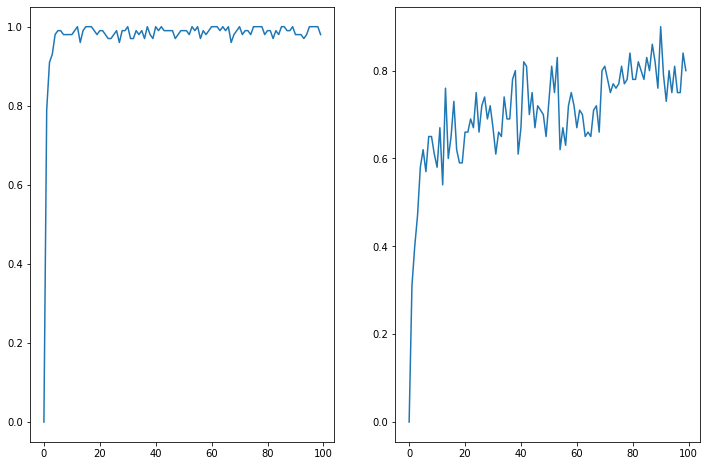

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 8))
axs[0].plot(range(len(eval_data['x'])), eval_data['x'])
axs[1].plot(range(len(eval_data['o'])), eval_data['o'])

### Доска 4x4

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150000/150000 [01:33<00:00, 1609.68it/s]

5066 5066


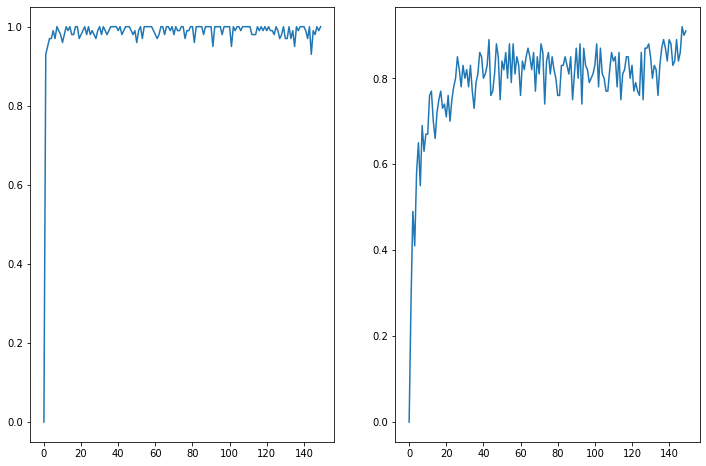

In [20]:
Q_x, Q_o, eval_data = q_learning(rows=4, cols=4, win=4,
                                 num_episodes=150000,
                                 epsilon=0.3,
                                 alpha=5e-2,
                                 eval_each=1000,
                                 eval_num_games=100)

print(len(Q_x.keys()), len(Q_o.keys()))

fig, axs = plt.subplots(1, 2, figsize=(12, 8))
axs[0].plot(range(len(eval_data['x'])), eval_data['x'])
axs[1].plot(range(len(eval_data['o'])), eval_data['o'])

### Доска 5x5

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150000/150000 [01:32<00:00, 1613.40it/s]

5228 5228


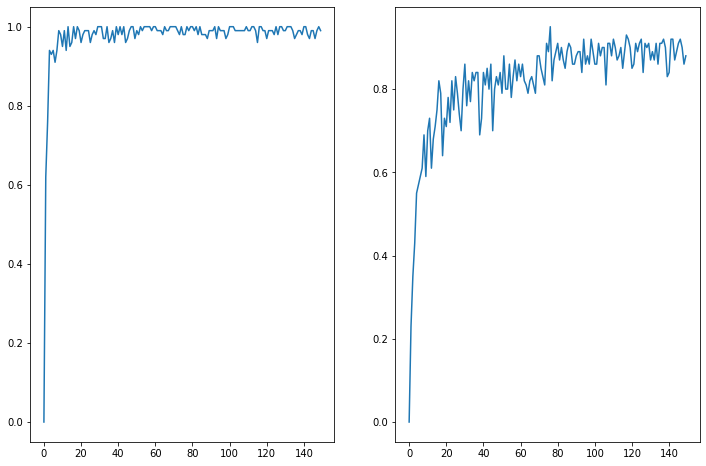

In [21]:
Q_x, Q_o, eval_data = q_learning(rows=5, cols=5, win=5,
                                 num_episodes=150000,
                                 epsilon=0.3,
                                 alpha=5e-2,
                                 eval_each=1000,
                                 eval_num_games=100)

print(len(Q_x.keys()), len(Q_o.keys()))

fig, axs = plt.subplots(1, 2, figsize=(12, 8))
axs[0].plot(range(len(eval_data['x'])), eval_data['x'])
axs[1].plot(range(len(eval_data['o'])), eval_data['o'])

## Часть вторая: добавим нейронных сетей
Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).  
$\;\;\;\;$3\. Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.  
$\;\;\;\;$4\. Реализуйте Double DQN и/или Dueling DQN.

In [ ]:
# not implemented yet

## Часть третья: расширим и углубим поиск
Крестики-нолики -- это, конечно, далеко не го, и обычный альфа-бета поиск с отсечением здесь наверняка может работать идеально вплоть до довольно больших досок. Однако мы всё-таки для этого учебного задания будем реализовывать более практически релевантный метод MCTS -- заодно фактически получится и упражнение на многоруких бандитов.  
$\;\;\;\;$5. Реализуйте rollouts со случайной стратегией и (опционально) rollouts с неслучайной, но простой стратегией (например, основанной на дополнении нескольких паттернов или на Q-функции, которая у вас получилась в первом пункте).  
$\;\;\;\;$6. Реализуйте MCTS-поиск с этими rollouts для крестиков-ноликов на досках разного размера, сравните полученные стратегии между собой и со стратегиями, обученными в первых двух частях.

In [ ]:
# not implemented yet

## Часть четвёртая, опциональная: AlphaZero
В опциональной части домашнего задания давайте попробуем всё-таки собрать всё вместе и завести настоящий AlphaZero. Если получится и будет обобщаться на большие доски, будет очень круто и будет стоить много дополнительных баллов.  
$\;\;\;\;$7. Реализуйте AlphaZero для крестиков-ноликов, используя MCTS из третьей части и DQN-сеть из второй части. Обучите стратегии для игры на больших досках (10х10 и выше, до пяти в ряд; опять же, может потребовать много времени, так что достаточно показать, что обучение началось и идёт).

In [ ]:
# not implemented yet